In [498]:
import torch
from torch import nn
import cv2
import numpy as np
import os
from PIL import Image
from collections import Counter
import torchvision
import selectivesearch
import torch.nn.functional as F
import torch.optim as optim
import cv2
import matplotlib.pyplot as plt

In [499]:
class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()

        def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
            layers = []
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                 kernel_size=kernel_size, stride=stride, padding=padding,
                                 bias=bias)]
            
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            layers += [nn.ReLU()]

            cbr = nn.Sequential(*layers)

            return cbr

        self.enc1_1 = CBR2d(in_channels=3, out_channels =64, kernel_size =3, stride=1, padding =1, bias =True)
        self.enc1_2 = CBR2d(in_channels=64, out_channels =64, kernel_size =3, stride=1, padding =1, bias =True)

        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.enc2_1 = CBR2d(in_channels=64, out_channels =128, kernel_size =3, stride=1, padding =1, bias =True)
        self.enc2_2 = CBR2d(in_channels=128, out_channels =128, kernel_size =3, stride=1, padding =1, bias =True)
        
        self.pool2 = nn.MaxPool2d(kernel_size =2)

        self.enc3_1 = CBR2d(in_channels=128, out_channels =256, kernel_size =3, stride=1, padding =1, bias =True)
        self.enc3_2 = CBR2d(in_channels=256, out_channels =256, kernel_size =3, stride=1, padding =1, bias =True)

        self.pool3 = nn.MaxPool2d(kernel_size =2)

        self.enc4_1 = CBR2d(in_channels=256, out_channels =512, kernel_size =3, stride=1, padding =1, bias =True)
        self.enc4_2 = CBR2d(in_channels=512, out_channels =512, kernel_size =3, stride=1, padding =1, bias =True)

        self.pool4 = nn.MaxPool2d(kernel_size =2)

        self.enc5_1 = CBR2d(in_channels=512, out_channels =1024, kernel_size =3, stride=1, padding =1, bias =True)
        self.enc5_2 = CBR2d(in_channels=1024, out_channels =1024, kernel_size =3, stride=1, padding =1, bias =True)

        self.dec5_1 = CBR2d(in_channels=1024, out_channels =512, kernel_size =3, stride=1, padding =1, bias =True)

        self.unpool4 = nn.ConvTranspose2d(in_channels =512, out_channels = 512, kernel_size = 2, stride = 2, padding = 0, bias = True)

        self.dec4_2 = CBR2d(in_channels=2 * 512, out_channels =512, kernel_size =3, stride=1, padding =1, bias =True)
        self.dec4_1 = CBR2d(in_channels=512, out_channels =256, kernel_size =3, stride=1, padding =1, bias =True)

        self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256,
                                          kernel_size=2, stride=2, padding=0, bias=True)
        self.dec3_2 = CBR2d(in_channels=2 * 256, out_channels=256)
        self.dec3_1 = CBR2d(in_channels=256, out_channels=128)

        self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128,
                                          kernel_size=2, stride=2, padding=0, bias=True)
        
        self.dec2_2 = CBR2d(in_channels=2 * 128, out_channels=128)
        self.dec2_1 = CBR2d(in_channels=128, out_channels=64)
        
        self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64,
                                          kernel_size=2, stride=2, padding=0, bias=True)
        
        self.dec1_2 = CBR2d(in_channels=2 * 64, out_channels=64)
        self.dec1_1 = CBR2d(in_channels=64, out_channels=64)

        self.fc = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)

    def forward(self, x):

        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)

        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)

        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)

        enc5_1 = self.enc5_1(pool4)
        enc5_2 = self.enc5_2(enc5_1)

        dec5_1 = self.dec5_1(enc5_2)
        
        unpool4 = self.unpool4(dec5_1)
        cat4 = torch.cat((unpool4, enc4_2),dim =1)
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)

        unpool3 = self.unpool3(dec4_1)
        cat3 = torch.cat((unpool3, enc3_2),dim =1)
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)

        unpool2 = self.unpool2(dec3_1)
        cat2 = torch.cat((unpool2, enc2_2),dim =1)
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)

        unpool1 = self.unpool1(dec2_1)
        cat1 = torch.cat((unpool1, enc1_2),dim =1)
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)

        x = self.fc(dec1_1)

        return x

In [500]:
model = torchvision.models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, 1024),
    nn.Dropout(0.2),
    nn.Linear(1024, 512),
    nn.Dropout(0.1),
    nn.Linear(512, 1),
    nn.Sigmoid()
)

In [501]:
class bounding_regression(nn.Module):
    def __init__(self):
        super(bounding_regression, self).__init__()
      
        self.fc1 = nn.Linear(4,64)
        self.fc2 = nn.Linear(64,32)
        self.fc3 = nn.Linear(32,16)
        self.fc4 = nn.Linear(16,4)
        self.drop = nn.Dropout(p=0.50)

    def forward(self, x):

        fc1 = F.relu(self.fc1(x))
        x = self.drop(x)
        fc2 = F.relu(self.fc2(fc1))
        x = self.drop(x)
        fc3 = F.relu(self.fc3(fc2))
        x = self.drop(x)
        fc4 = self.fc4(fc3)
    
        return fc4

In [502]:
device = "cuda" if torch.cuda.is_available() else "cpu"
segmentation_model = torch.load("segmentation.pt", map_location=device)
boxregression_model = torch.load("boundingbox.pt", map_location=device)
CNN_model = torch.load("CNN.pt", map_location=device)
print(segmentation_model)
print(boxregression_model)
print(CNN_model)
# with torch.no_grad():
#     model.eval()
#     inputs = torch.FloatTensor([[1 ** 2, 1], [5 **2, 5], [11**2, 11]]).to(device)
#     outputs = model(inputs)
#     print(outputs)

Unet(
  (enc1_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (enc1_2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2_1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (enc2_2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

>bounding box regression

In [503]:
fn_tonumpy = lambda x: x.to('cpu').detach().numpy().transpose(1,2,0)

from typing import Any


class Normalization(object):
  def __init__(self, mean=0.5 , std=0.5):
    self.mean = mean
    self.std = std
  
  def __call__(self, data):

    data =(data - self.mean) / self.std

    return data

class image2np(object):
  def __init__(self, label):
    self.label = label

  def __call__(self, img):
    img = np.array(img, dtype=np.float32)
    if img.ndim == 2:
      img = img[:, :, np.newaxis]
    if self.label:
      img = np.where(img == 0, 0, 255)
    return img/255
  
class img2coor(object):
  def __call__(self, img):
    x, y = np.nonzero(img)
    return torch.Tensor(np.array([x[0],y[0],x[-1],y[-1]])) # top left bottom right
  
import selectivesearch 

def selective(img):
    _, region = selectivesearch.selective_search(img, scale = 50, min_size=2000)
    cand_rects = [cand['rect'] for cand in region]
    res = []
    for rect in cand_rects:
        
        left = rect[0]
        top = rect[1]
        right = left + rect[2]
        bottom = top + rect[3]
        tmp = torch.tensor(np.array([top,left,bottom,right]))
        res.append(tmp)
          #  copy_img = cv2.rectangle(copy_img, (left,top), (right,bottom),color=(0,255,10),thickness=2)
           
    # plt.imshow(copy_img)
    # plt.show()
    
    return res 

def intersection_over_union(boxes_preds, boxes_labels, box_format='corners'):
    
    if box_format == 'corners':
        box1_y1 = boxes_preds[..., 0:1] # (N,1)
        box1_x1 = boxes_preds[..., 1:2]
        box1_y2 = boxes_preds[..., 2:3]
        box1_x2 = boxes_preds[..., 3:4]
        box2_y1 = boxes_labels[..., 0:1]
        box2_x1 = boxes_labels[..., 1:2]
        box2_y2 = boxes_labels[..., 2:3]
        box2_x2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)
    
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))
    return intersection / (box1_area + box2_area - intersection + 1e-6)

def preview(img, c1):
    # print(img.shape)
    img = fn_tonumpy(img)
    copy = img.copy()
    c = (0,10,0)
    text = 'before'
    coor = 40
    for rect in [c1]:    
      # print(rect)
      top = int(rect[0])
      left = int(rect[1])
      bottom = int(rect[2])
      right = int(rect[3])
      copy = cv2.rectangle(copy, (left,top), (right,bottom),color=c,thickness=2)
      cv2.putText(copy, text,(left,top+coor) , cv2.FONT_HERSHEY_DUPLEX, .8, c)
      c = (255,0,10)
      text = 'after'
      coor = 120
    # plt.imshow(copy)
    # plt.show()

def make_tensor(data):
  #  print(data.numpy().shape[0])
   if data.numpy().shape[0] == 4:
      data = data[:3,:,:]
      # print(data.shape)
   tmp = selective(data.numpy().transpose(1,2,0))
   return tmp
 
def crop_img(img, c1):
   img = fn_tonumpy(img)
   copy = img.copy()
   c = (0,10,0)
   text = 'before'
   coor = 40
   for rect in [c1]:    
     top = int(rect[0])
     left = int(rect[1])
     bottom = int(rect[2])
     right = int(rect[3])
     copy = cv2.rectangle(copy, (left,top), (right,bottom),color=c,thickness=2)
     cv2.putText(copy, text,(left,top+coor) , cv2.FONT_HERSHEY_DUPLEX, .8, c)
     c = (255,0,10)
     text = 'after'
     coor = 120
    # plt.imshow(copy)
    # plt.show()
   return img[top:bottom+1,left:right+1,:], [left,top, right,bottom]

In [504]:
from PIL import Image 
import torchvision.transforms as transforms

dir = './data/10.png'
input = Image.open(dir)
input = image2np(label = False)(input)
input = transforms.ToTensor()(input)

In [505]:
check_minus = lambda x: x * 1.0 * (x>0)
boxregression_model.eval() 
with torch.no_grad(): 
        cropped_arr = []
        coor_arr = []
        datas = make_tensor(input)                
        transform = transforms.Compose([
               image2np(label=False),
               Normalization(mean= 0.5, std =0.5),
               transforms.ToTensor()
        ])
        for data in datas:
                data = data.float().to(device)
                hypothesis = boxregression_model(data) 
                preview(input, hypothesis)
                hypothesis = check_minus(hypothesis)
                cropped_img, coor = crop_img(input, hypothesis)
                cropped_img =cropped_img*255
                cropped_img = Image.fromarray(cropped_img.astype(np.uint8)).resize((512,512))
                cropped_arr.append(transform(cropped_img))
                coor_arr.append(coor)
                # plt.imshow(cropped_img)
                # plt.show()

if device == 'cuda':
    torch.cuda.empty_cache() # 캐시 쌓임에 다른 속도저하 방지차 GPU 메모리 초기화

In [506]:
def marker(img, c1, pred):
    # print(type(img))
    if type(img) ==torch.Tensor:
        img = img.numpy().transpose(1,2,0)
    copy = img.copy()
    c = (0,10,0) if pred == 0 else (255,0,10)
    text = 'good' if pred == 0 else 'bad'
    coor = 40
    left,top, right,bottom = c1
    copy = cv2.rectangle(copy, (left,top), (right,bottom),color=c,thickness=2)
    cv2.putText(copy, text,(left,top+coor) , cv2.FONT_HERSHEY_DUPLEX, .8, c)
    return copy


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([11, 4])
0.25439453125
0.23276901245117188
0.17549896240234375
0.10387420654296875


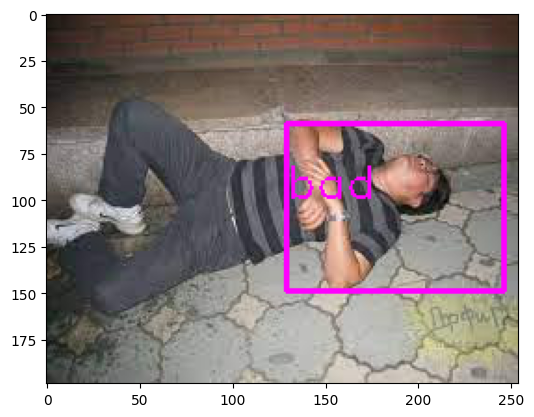

In [507]:
fn_tonumpy = lambda x: x.to('cpu').detach().numpy().transpose(0, 2, 3, 1)
fn_class = lambda x: 1.0 * (x > 0.5)
fn_class2 = lambda x: x + 1.0 * (x == 0)
res = []
score_arr = []
with torch.no_grad():
    for data,coor in zip(cropped_arr,coor_arr):
        # transforms.ToPILImage()(((data[0].cpu()))).show()
        data = data[None,:,:,:].to('cuda') if data.shape[0] != 4 else data[None,:3,:,:]
        # print(data)
        data = data.to('cuda')
        out = segmentation_model(data)
        out = fn_class(out)
        PIL_out = fn_tonumpy(out)[0][:,:,0]
        score = PIL_out[np.where(PIL_out == 1)].size/PIL_out.size
        score_arr.append(score)
        
print(torch.tensor(np.array(coor_arr)).shape)            
nms_idx = torchvision.ops.nms(torch.tensor(np.array(coor_arr)).float(),scores=torch.tensor(np.array(score_arr)).float(),iou_threshold=0.4)
# print(nms_idx)
for idx in nms_idx:
    print(score_arr[idx])
    if score_arr[idx] > 0.25 :
            pred = CNN_model(data)
            # print(pred)
            pred[pred >= 0.5] = 1
            pred[pred < 0.5] = 0
            # print(pred)
            # print(input.shape)
            input = marker(input, coor_arr[idx], int(pred[0]))
if type(input) == torch.Tensor:
    input = transforms.ToPILImage()(input)
plt.imshow(input)
plt.show()  